# Проект: вариант 1

## Задание 1

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime

import requests 
from urllib.parse import urlencode

In [2]:
# Я загрузил таблицы на яндекс-диск, для возможности работать как в LMS, так и локально
# Загрузим наши данные с Яндекс-диска:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

public_key_auth = 'https://disk.yandex.ru/d/QEUn6SPg_ZzxPQ'
final_url_auth = base_url + urlencode(dict(public_key=public_key_auth)) 
response_auth = requests.get(final_url_auth) 
download_url_auth = response_auth.json()['href'] 

public_key_reg = 'https://disk.yandex.ru/d/Rnv5RpXqUQZwkQ'
final_url_reg = base_url + urlencode(dict(public_key=public_key_reg)) 
response_reg = requests.get(final_url_reg) 
download_url_reg = response_reg.json()['href']

In [3]:
# загрузим наши данные с яндекс диска
reg_data = pd.read_csv(download_url_reg, sep=';')
auth_data = pd.read_csv(download_url_auth, sep=';')

### 1.1 Базовая проверка данных

In [4]:
print('Размеры таблицы:', reg_data.shape)
print('Типы данных:\n', reg_data.dtypes)
reg_data.head()

Размеры таблицы: (1000000, 2)
Типы данных:
 reg_ts    int64
uid       int64
dtype: object


,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


Пока что всё что мы имеем -  это дата регистрации в формате таймштампа и id пользователя.  
Поэтому быстро глянем на таблицу авторизаций и начинаем создавать необходимую нам функцию.

In [5]:
print('Размеры таблицы:', auth_data.shape)
print('Типы данных:\n', auth_data.dtypes)
auth_data.head()

Размеры таблицы: (9601013, 2)
Типы данных:
 auth_ts    int64
uid        int64
dtype: object


,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Размер таблицы внушительный! Нужно будет осторожно выбирать методы рассчетов, чтобы ноутбук не умер в процессе от перегрева.

### 1.2 Подготовка и тестирование форматов вывода данных

In [6]:
# объединим данные в одну таблицу
df = auth_data.merge(reg_data, how='left', on='uid')
df.head(3)

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089


In [8]:
# приведем столбцы с таймштампами к читаемому виду и запишем в новые столбцы
df['auth_date'] = pd.to_datetime(df['auth_ts'], unit='s').dt.date
df['reg_date'] = pd.to_datetime(df['reg_ts'], unit='s').dt.date
df.head(3)

,auth_ts,uid,reg_ts,auth_date,reg_date
0,911382223,1,911382223,1998-11-18,1998-11-18
1,932683089,2,932683089,1999-07-22,1999-07-22
2,932921206,2,932683089,1999-07-25,1999-07-22


In [9]:
# посмотрим диапазон дат в наших данных
print('Первая регистрация   : ', df['reg_date'].min())
print('Первая авторизация   : ', df['auth_date'].min())
print('Последняя регистрация: ', df['reg_date'].max())
print('Последняя авторизация: ', df['auth_date'].max())

Первая регистрация   :  1998-11-18
Первая авторизация   :  1998-11-18
Последняя регистрация:  2020-09-23
Последняя авторизация:  2020-09-23


#### Проверка когортного анализа по дням

In [10]:
# Задаём период анализа
start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2018, 1, 31)

In [11]:
# Добавим столбец с количеством ДНЕЙ с момента регистрации
df['days_since_reg'] = ((df.auth_date - df.reg_date) / np.timedelta64(1, 'D')).astype(int)

In [12]:
# отфилтруем данные за необходимый период
df_filtred = df.query('reg_date >= @start_date and auth_date <= @end_date')
print(df_filtred.size)

102942


In [13]:
# Создадим таблицу для когортного анализа, когорты делим по дате регистрации
cohorts = df_filtred.groupby(['reg_date', 'days_since_reg'], as_index=False)\
    .agg({'uid': 'nunique'})\
    .pivot(index='reg_date', columns='days_since_reg', values='uid')
cohorts.head()

days_since_reg,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,320.0,5.0,11.0,8.0,20.0,28.0,19.0,12.0,11.0,18.0,...,14.0,12.0,8.0,7.0,11.0,8.0,12.0,8.0,14.0,6.0
2018-01-02,320.0,4.0,18.0,14.0,19.0,17.0,22.0,12.0,17.0,10.0,...,8.0,10.0,14.0,3.0,14.0,5.0,6.0,8.0,8.0,NaN
2018-01-03,320.0,5.0,11.0,26.0,21.0,23.0,21.0,14.0,13.0,23.0,...,19.0,6.0,13.0,11.0,9.0,10.0,12.0,10.0,NaN,NaN
2018-01-04,322.0,5.0,19.0,14.0,22.0,15.0,24.0,24.0,16.0,24.0,...,13.0,14.0,21.0,9.0,14.0,10.0,12.0,NaN,NaN,NaN
2018-01-05,321.0,5.0,19.0,15.0,16.0,15.0,27.0,26.0,15.0,19.0,...,16.0,6.0,17.0,14.0,15.0,13.0,NaN,NaN,NaN,NaN


In [14]:
# Теперь найдем показатель retention для наших данных относительно даты регистрации
cohorts.div(cohorts[0], axis=0).head()

days_since_reg,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.0,0.015625,0.034375,0.025000,0.062500,0.087500,0.059375,0.037500,0.034375,0.056250,...,0.043750,0.037500,0.025000,0.021875,0.034375,0.025000,0.037500,0.02500,0.04375,0.01875
2018-01-02,1.0,0.012500,0.056250,0.043750,0.059375,0.053125,0.068750,0.037500,0.053125,0.031250,...,0.025000,0.031250,0.043750,0.009375,0.043750,0.015625,0.018750,0.02500,0.02500,NaN
2018-01-03,1.0,0.015625,0.034375,0.081250,0.065625,0.071875,0.065625,0.043750,0.040625,0.071875,...,0.059375,0.018750,0.040625,0.034375,0.028125,0.031250,0.037500,0.03125,NaN,NaN
2018-01-04,1.0,0.015528,0.059006,0.043478,0.068323,0.046584,0.074534,0.074534,0.049689,0.074534,...,0.040373,0.043478,0.065217,0.027950,0.043478,0.031056,0.037267,NaN,NaN,NaN
2018-01-05,1.0,0.015576,0.059190,0.046729,0.049844,0.046729,0.084112,0.080997,0.046729,0.059190,...,0.049844,0.018692,0.052960,0.043614,0.046729,0.040498,NaN,NaN,NaN,NaN


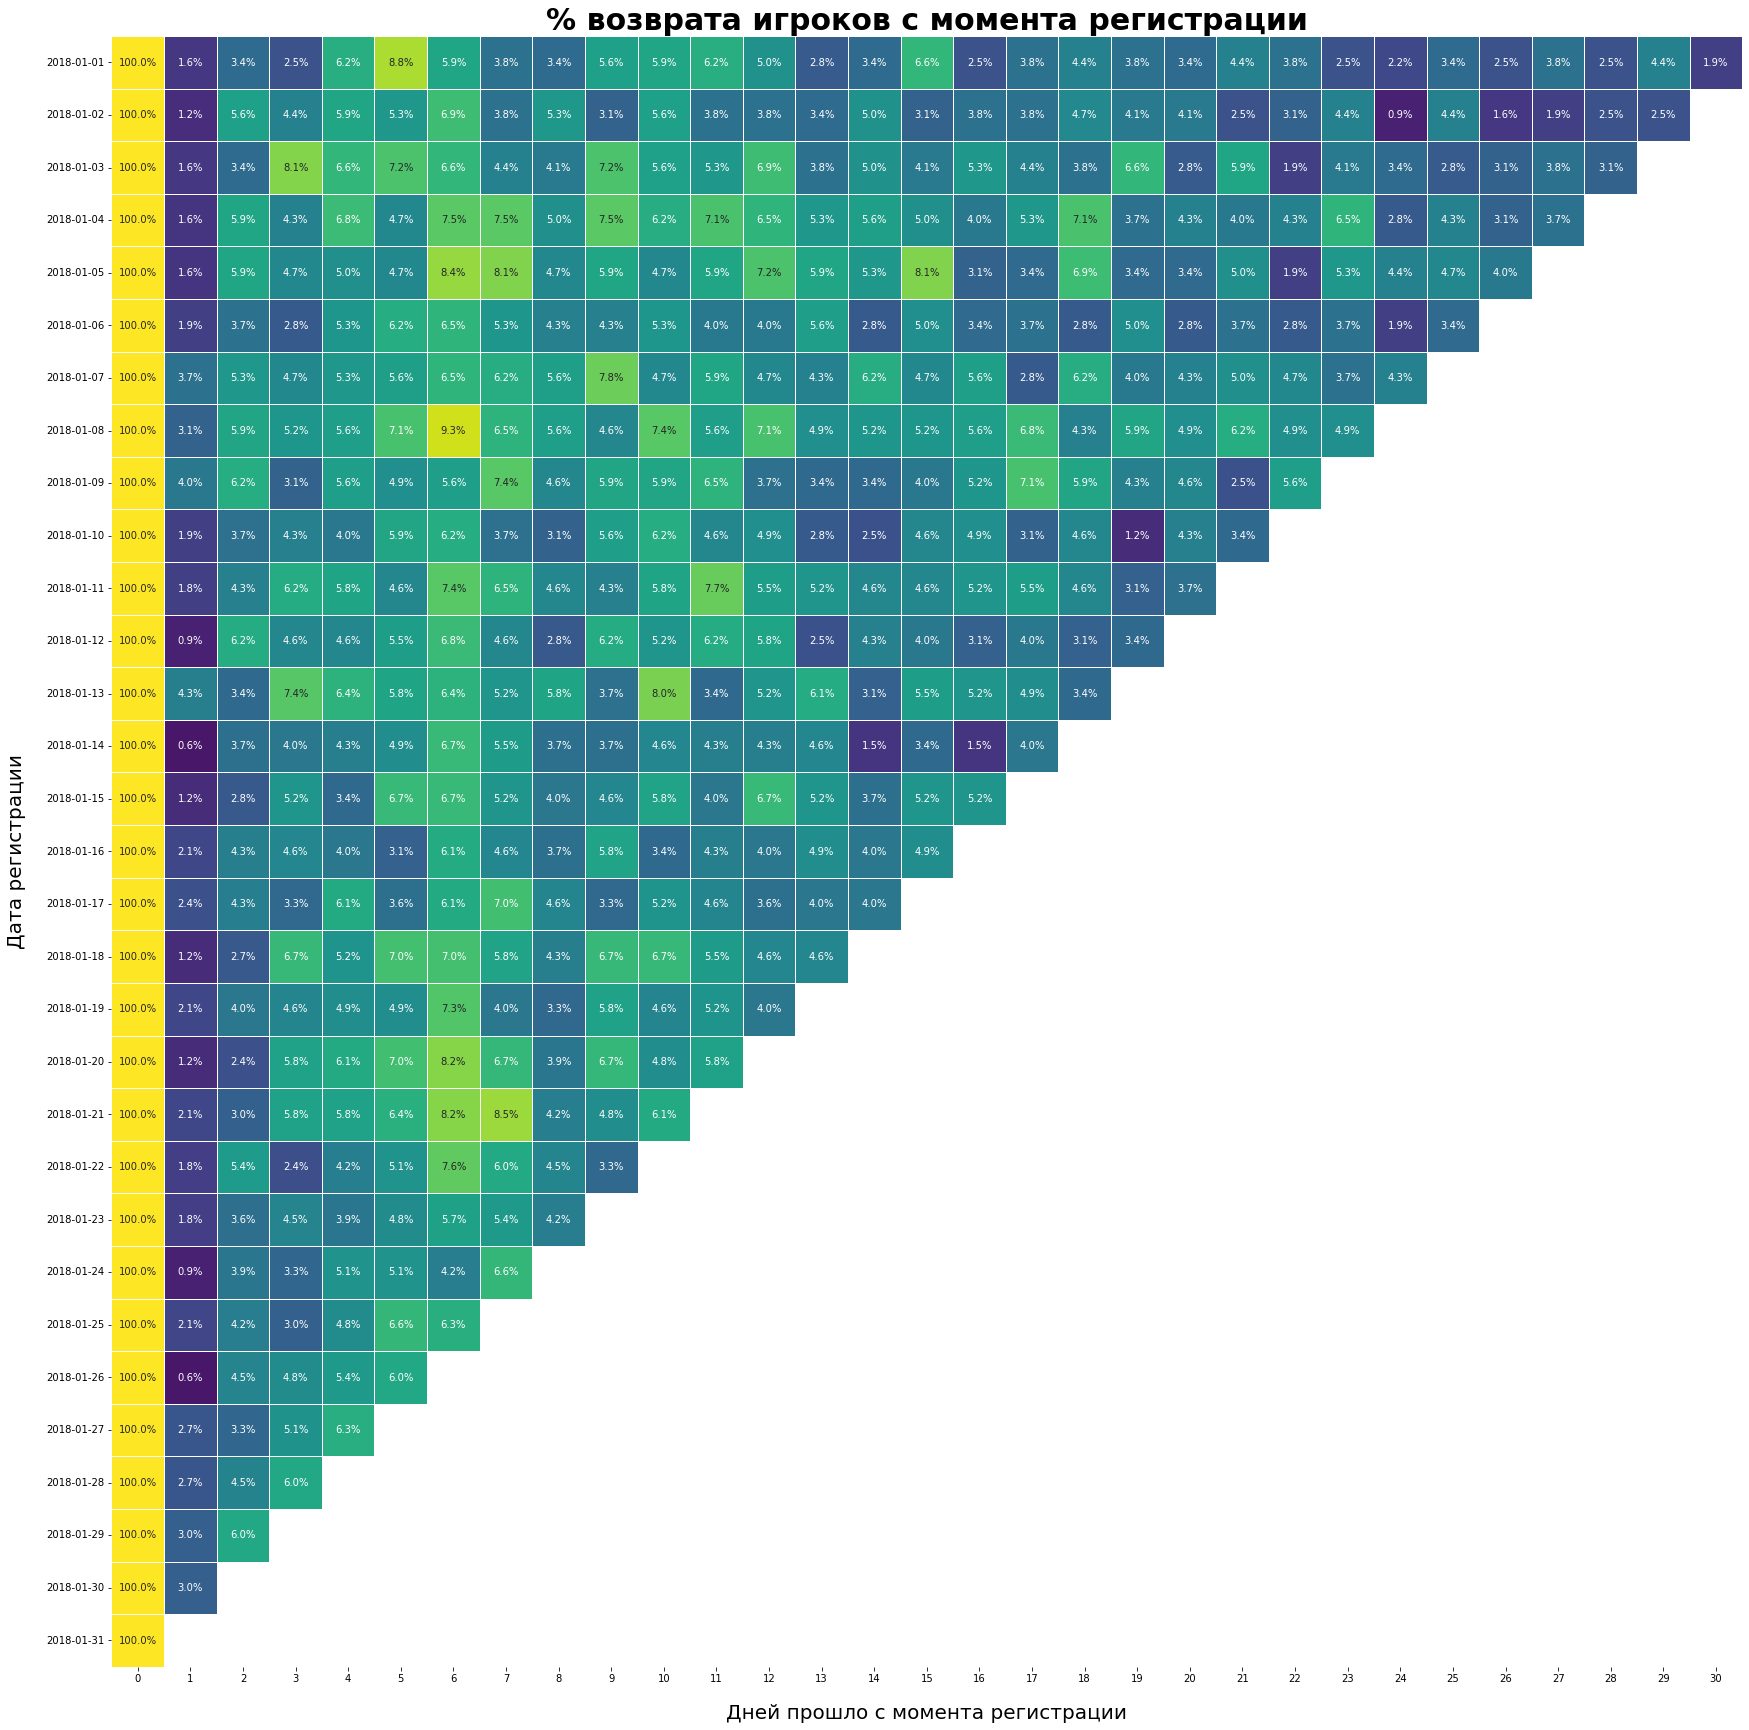

In [17]:
# ...и наконец построим красивую и понятную визуализацию для наших данных
plt.figure(figsize=(30, 30))
plt.title('% возврата игроков с момента регистрации', fontweight='bold', size=30)
sns.heatmap(cohorts.div(cohorts[0], axis=0), vmin=0.0, vmax=0.1, cmap='viridis', 
            fmt='.1%', annot=True, linewidths=1, linecolor='white', square=True, cbar=False)
plt.ylabel('Дата регистрации', labelpad=20, size=20)
plt.xlabel('Дней прошло с момента регистрации', labelpad=20, size=20)
None

#### Тест когорт по месяцам

In [18]:
# Задаём период анализа:
start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2018, 12, 31)

In [19]:
df['reg_month'] = pd.to_datetime(df['reg_ts'], unit='s').dt.to_period('M')

In [20]:
# Добавим столбец с количеством МЕСЯЦЕВ с момента регистрации
df['months_since_reg'] = ((df.auth_date - df.reg_date) / np.timedelta64(1, 'M')).astype(int)

In [21]:
# Отфильтруем данные за необходимый период
df_filtred = df.query('reg_date >= @start_date and auth_date <= @end_date')
print(df_filtred.size)

5154376


In [22]:
cohorts_month = df_filtred.groupby(['reg_month', 'months_since_reg'], as_index=False)\
    .agg({'uid': 'nunique'})\
    .pivot(index='reg_month', columns='months_since_reg', values='uid')
cohorts_month

months_since_reg,0,1,2,3,4,5,6,7,8,9,10,11
reg_month,,,,,,,,,,,,
2018-01,10156.0,1021.0,488.0,488.0,488.0,488.0,488.0,488.0,488.0,488.0,488.0,430.0
2018-02,9630.0,989.0,491.0,491.0,491.0,491.0,491.0,491.0,491.0,491.0,472.0,NaN
2018-03,11191.0,1163.0,571.0,571.0,571.0,571.0,571.0,571.0,571.0,551.0,5.0,NaN
2018-04,11387.0,1178.0,602.0,602.0,602.0,602.0,602.0,602.0,575.0,2.0,NaN,NaN
2018-05,12372.0,1321.0,632.0,632.0,632.0,632.0,632.0,597.0,8.0,NaN,NaN,NaN
2018-06,12588.0,1318.0,660.0,660.0,660.0,660.0,624.0,NaN,NaN,NaN,NaN,NaN
2018-07,13678.0,1382.0,655.0,655.0,655.0,615.0,5.0,NaN,NaN,NaN,NaN,NaN
2018-08,14392.0,1441.0,701.0,701.0,646.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09,14645.0,1446.0,732.0,694.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Найдем показатель retention для наших данных относительно даты регистрации
cohorts_month.div(cohorts_month[0], axis=0)

months_since_reg,0,1,2,3,4,5,6,7,8,9,10,11
reg_month,,,,,,,,,,,,
2018-01,1.0,0.100532,0.048050,0.048050,0.048050,0.048050,0.048050,0.048050,0.048050,0.048050,0.048050,0.04234
2018-02,1.0,0.102700,0.050987,0.050987,0.050987,0.050987,0.050987,0.050987,0.050987,0.050987,0.049013,NaN
2018-03,1.0,0.103923,0.051023,0.051023,0.051023,0.051023,0.051023,0.051023,0.051023,0.049236,0.000447,NaN
2018-04,1.0,0.103451,0.052867,0.052867,0.052867,0.052867,0.052867,0.052867,0.050496,0.000176,NaN,NaN
2018-05,1.0,0.106773,0.051083,0.051083,0.051083,0.051083,0.051083,0.048254,0.000647,NaN,NaN,NaN
2018-06,1.0,0.104703,0.052431,0.052431,0.052431,0.052431,0.049571,NaN,NaN,NaN,NaN,NaN
2018-07,1.0,0.101038,0.047887,0.047887,0.047887,0.044963,0.000366,NaN,NaN,NaN,NaN,NaN
2018-08,1.0,0.100125,0.048708,0.048708,0.044886,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09,1.0,0.098737,0.049983,0.047388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


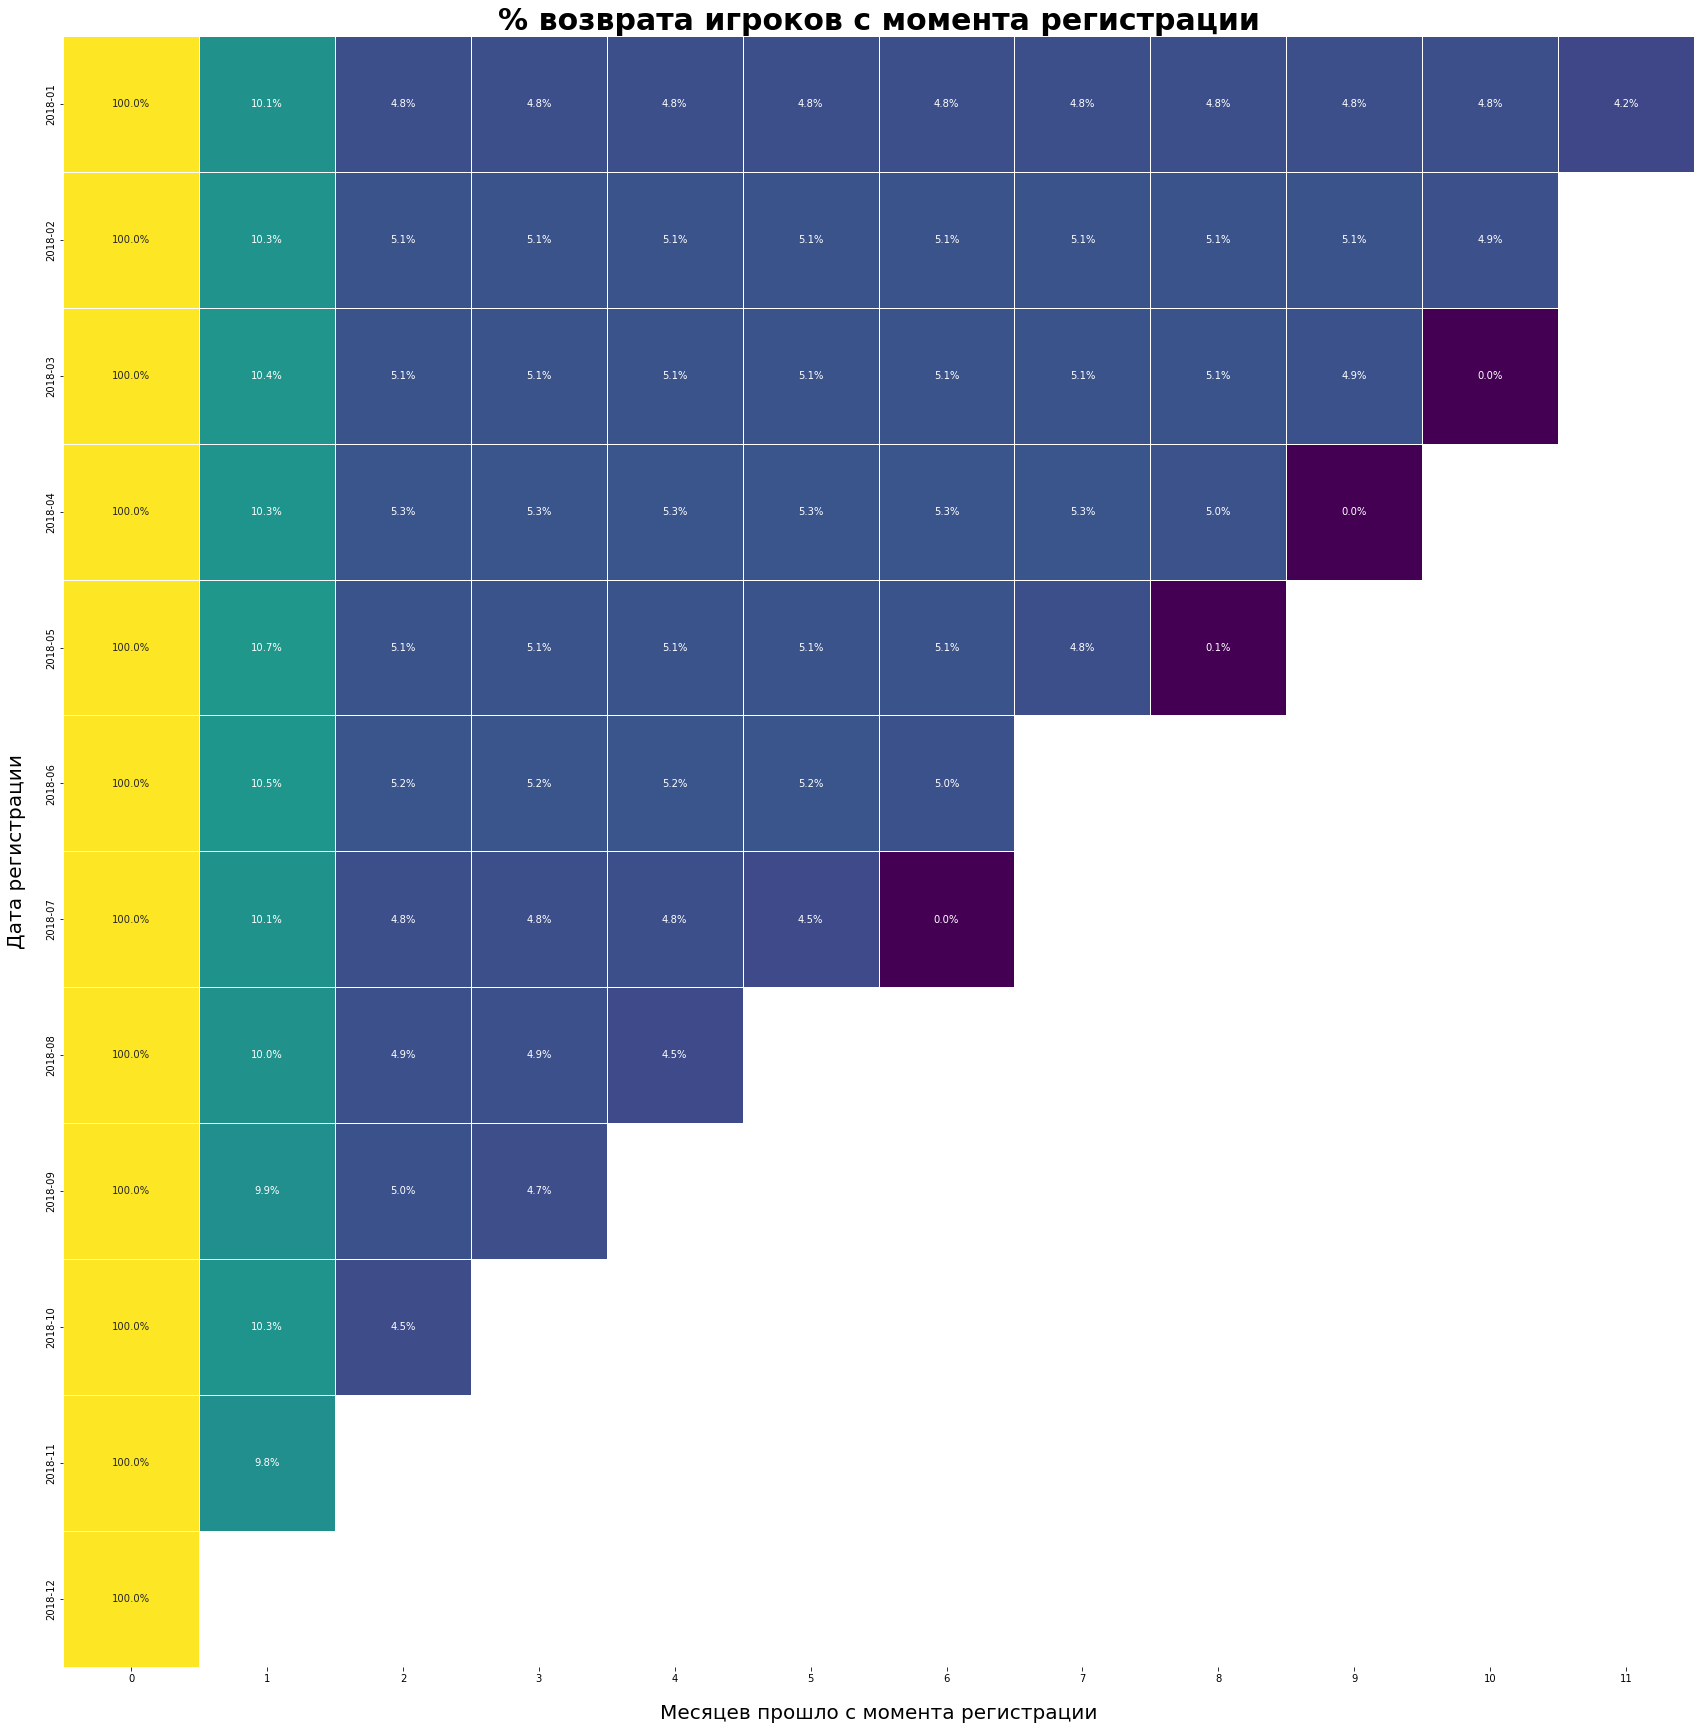

In [25]:
plt.figure(figsize=(30, 30))
plt.title('% возврата игроков с момента регистрации', fontweight='bold', size=30)
sns.heatmap(cohorts_month.div(cohorts_month[0], axis=0), vmin=0.0, vmax=0.2, cmap='viridis', 
            fmt='.1%', annot=True, linewidths=1, linecolor='white', square=True, cbar=False)
plt.ylabel('Дата регистрации', labelpad=20, size=20)
plt.xlabel('Месяцев прошло с момента регистрации', labelpad=20, size=20)
None

#### Проверка когорт по годам

In [26]:
# Всё тоже самое по годам
df['reg_year'] = pd.to_datetime(df['reg_ts'], unit='s').dt.year

In [27]:
df['years_since_reg'] = ((df.auth_date - df.reg_date) / np.timedelta64(1, 'Y')).astype(int)

In [28]:
cohorts_years = df.groupby(['reg_year', 'years_since_reg'], as_index=False)\
    .agg({'uid': 'nunique'})\
    .pivot(index='reg_year', columns='years_since_reg', values='uid')
cohorts_years

years_since_reg,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
reg_year,,,,,,,,,,,,,,,,,,,,,
1998,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,65.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2006,119.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


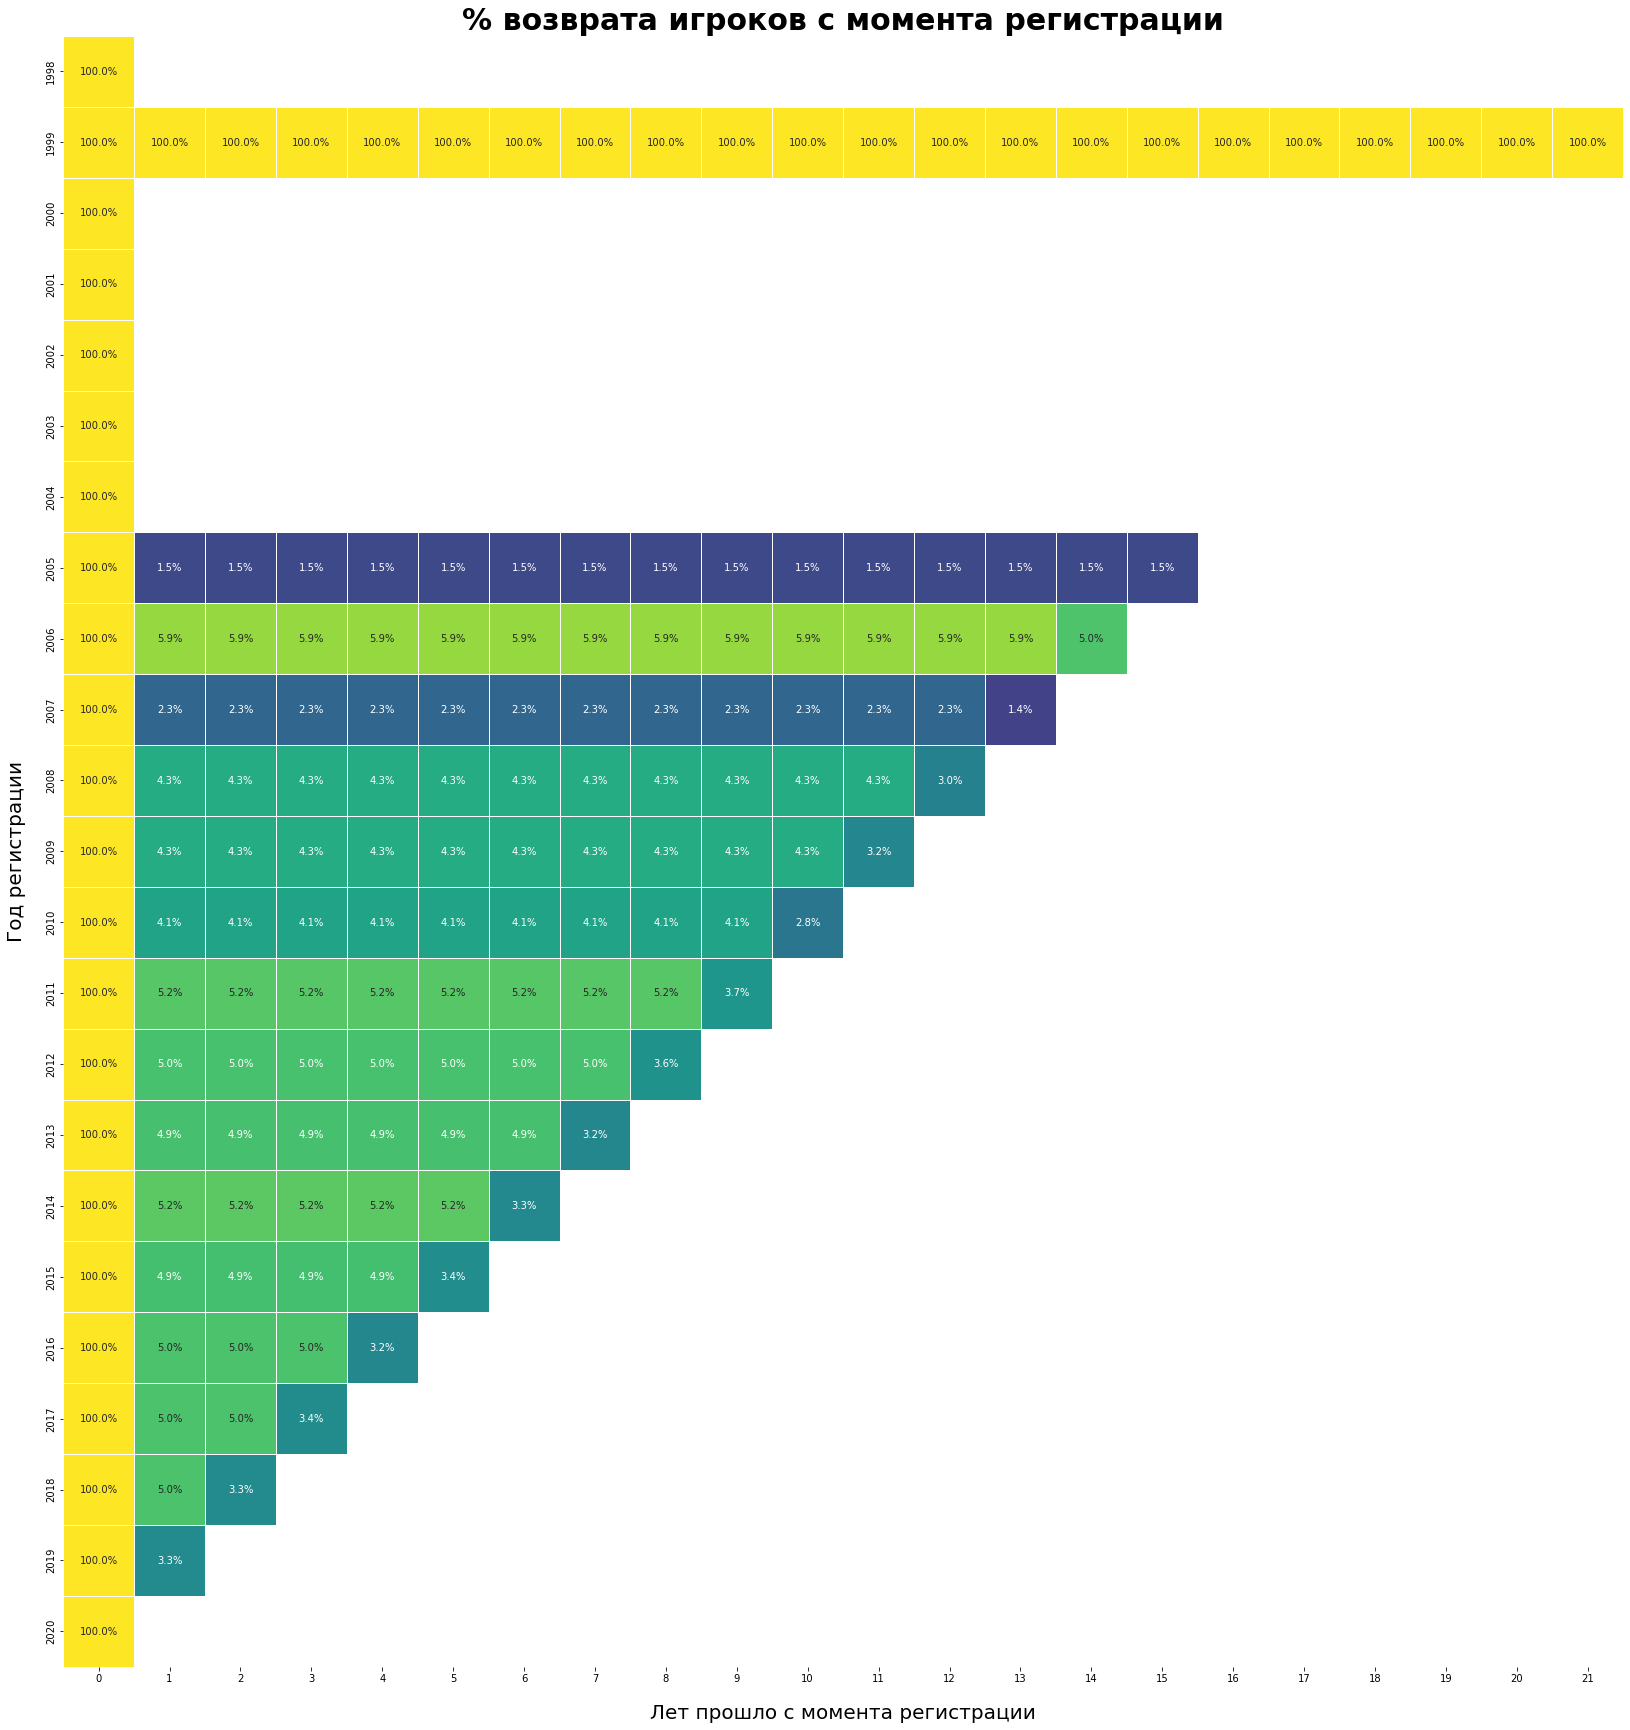

In [30]:
plt.figure(figsize=(30, 30))
plt.title('% возврата игроков с момента регистрации', fontweight='bold', size=30)
sns.heatmap(cohorts_years.div(cohorts_years[0], axis=0), vmin=0.0, vmax=0.07, cmap='viridis', 
            fmt='.1%', annot=True, linewidths=1, linecolor='white', square=True, cbar=False)
plt.ylabel('Год регистрации', labelpad=20, size=20)
plt.xlabel('Лет прошло с момента регистрации', labelpad=20, size=20)
None

Если мы всё правильно посчитали, то из графика выше можно сделать вывод, что наши данные с большой вероятностью созданы искуственно - очень сложно представить, что неизменный процент игроков играет в одну и ту же игру десятилетиями

#### Тест вывода когорт в виде линейного графика

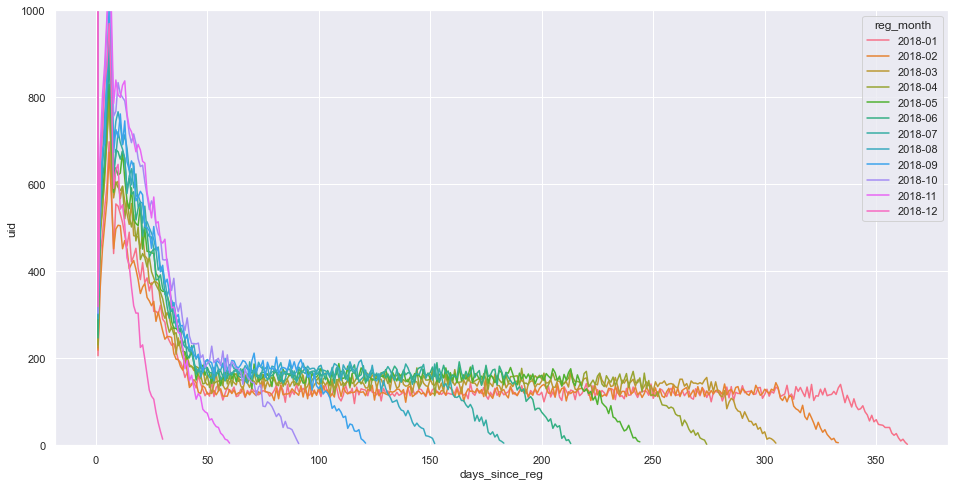

In [32]:
retention_plot = df_filtred.groupby(['reg_month', 'days_since_reg'], as_index=False).agg({'uid': 'nunique'})
sns.set(rc={'figure.figsize': (16, 8)})
sns.lineplot(data=retention_plot, x='days_since_reg', y='uid', hue='reg_month')
# plt.xlim(1,)
plt.ylim(0, 1000)
None

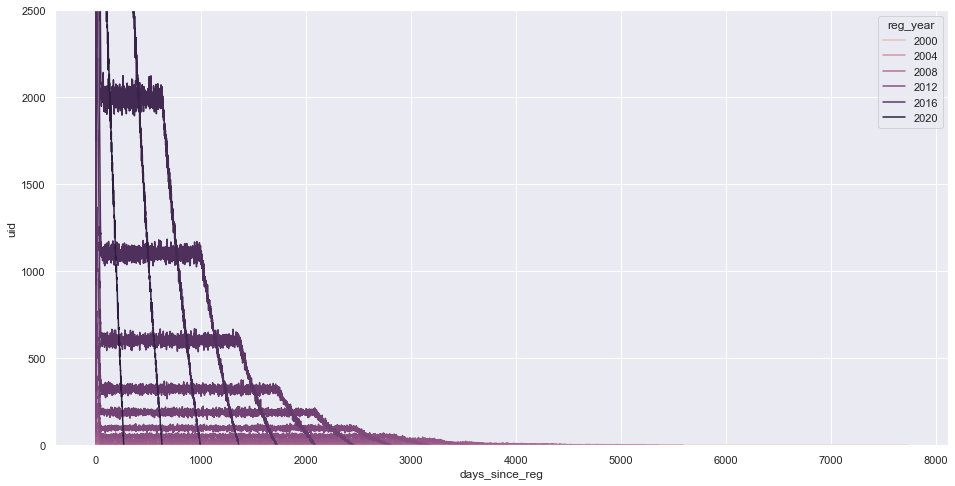

In [33]:
# Еще один тест
retention_plot = df.groupby(['reg_year', 'days_since_reg'], as_index=False).agg({'uid': 'nunique'})
sns.set(rc={'figure.figsize': (16, 8)})
sns.lineplot(data=retention_plot, x='days_since_reg', y='uid', hue='reg_year')
# plt.xlim(1, 4000)
plt.ylim(0, 2500)
None

### 1.3 Собираем функцию

На вход функции подаются следующие данные:
* reg_data - данные о регистрации пользователей
* auth_data - данные о авторизации пользователей в игре
* period - переменная используется для масштаба графиков и таблиц. Может принимать значения:
    * 'D' - по дням
    * 'M' - по месяцам
    * 'Y' - по годам
* start_date - дата начала отчетного периода
* end_date - дата окончания отчетного периода
* style - стиль отображения посчитанных данных. Может принимать значения:
    * 'heatmap' - тепловая карта
    * 'lineplot' - линейный график
    * 'table' - в виде таблицы

In [35]:
def retention(reg_data, auth_data, period, start_date, end_date, style):
    ''' 
    Относительно тестового варианта в функции изменил метод рассчета и ускорил работу в ~100 раз. Это достигается 
    переводом даты начала и конца периода в формат int-таймштампа (как изначачально в таблице) и фильтации данных
    по ним. Конвертация форматов датафрейма и все рассчеты производятся только на нужном куске данных.
    '''
    start_date = time.mktime(datetime.datetime.strptime(start_date, "%Y-%m-%d").timetuple())
    end_date = time.mktime(datetime.datetime.strptime(end_date, "%Y-%m-%d").timetuple())
    
    df = auth_data.merge(reg_data, how='left', on='uid')\
        .query('reg_ts >= @start_date and auth_ts <= @end_date')

    df['auth_date'] = pd.to_datetime(df['auth_ts'], unit='s').dt.date
    df['reg_date'] = pd.to_datetime(df['reg_ts'], unit='s').dt.date

    df['period'] = ((df.auth_date - df.reg_date) / np.timedelta64(1, period)).astype(int)
    df['start'] = pd.to_datetime(df['reg_ts'], unit='s').dt.to_period(period)
    
    cohorts = df.groupby(['start', 'period'], as_index=False)\
        .agg({'uid': 'nunique'})\
        .pivot(index='start', columns='period', values='uid')
    
    if style == 'heatmap':
        plt.figure(figsize=(30, 30))
        plt.title('% возврата игроков', fontweight='bold', size=30)
        sns.heatmap(cohorts.div(cohorts[0], axis=0), vmin=0.0, vmax=0.07, cmap='viridis', 
                    fmt='.1%', annot=True, linewidths=1, linecolor='white', square=True, cbar=False)
        plt.ylabel('Дата регистрации', labelpad=20, size=20)
        plt.xlabel('Времени прошло с момента регистрации', labelpad=20, size=20)
        return 'Heatmap'
    
    elif style == 'lineplot':
        retention_plot = df.groupby(['start', 'period'], as_index=False).agg({'uid': 'nunique'})
        sns.set(rc={'figure.figsize': (16, 8)})
        sns.lineplot(data=retention_plot, x='period', y='uid', hue='start')
        plt.ylim(0, 1000)
        return 'Lineplot'
    
    elif style == 'table':
        return cohorts
    else:
        return "переменная 'style' задана не верно"

In [36]:
# проверка "защиты от дурака". В перспектив есть идея добавить её для всех аргументов.
retention(reg_data, auth_data, 'D', '2018-01-01', '2018-01-15', 'abracadabra')

"переменная 'style' задана не верно"

'Heatmap'

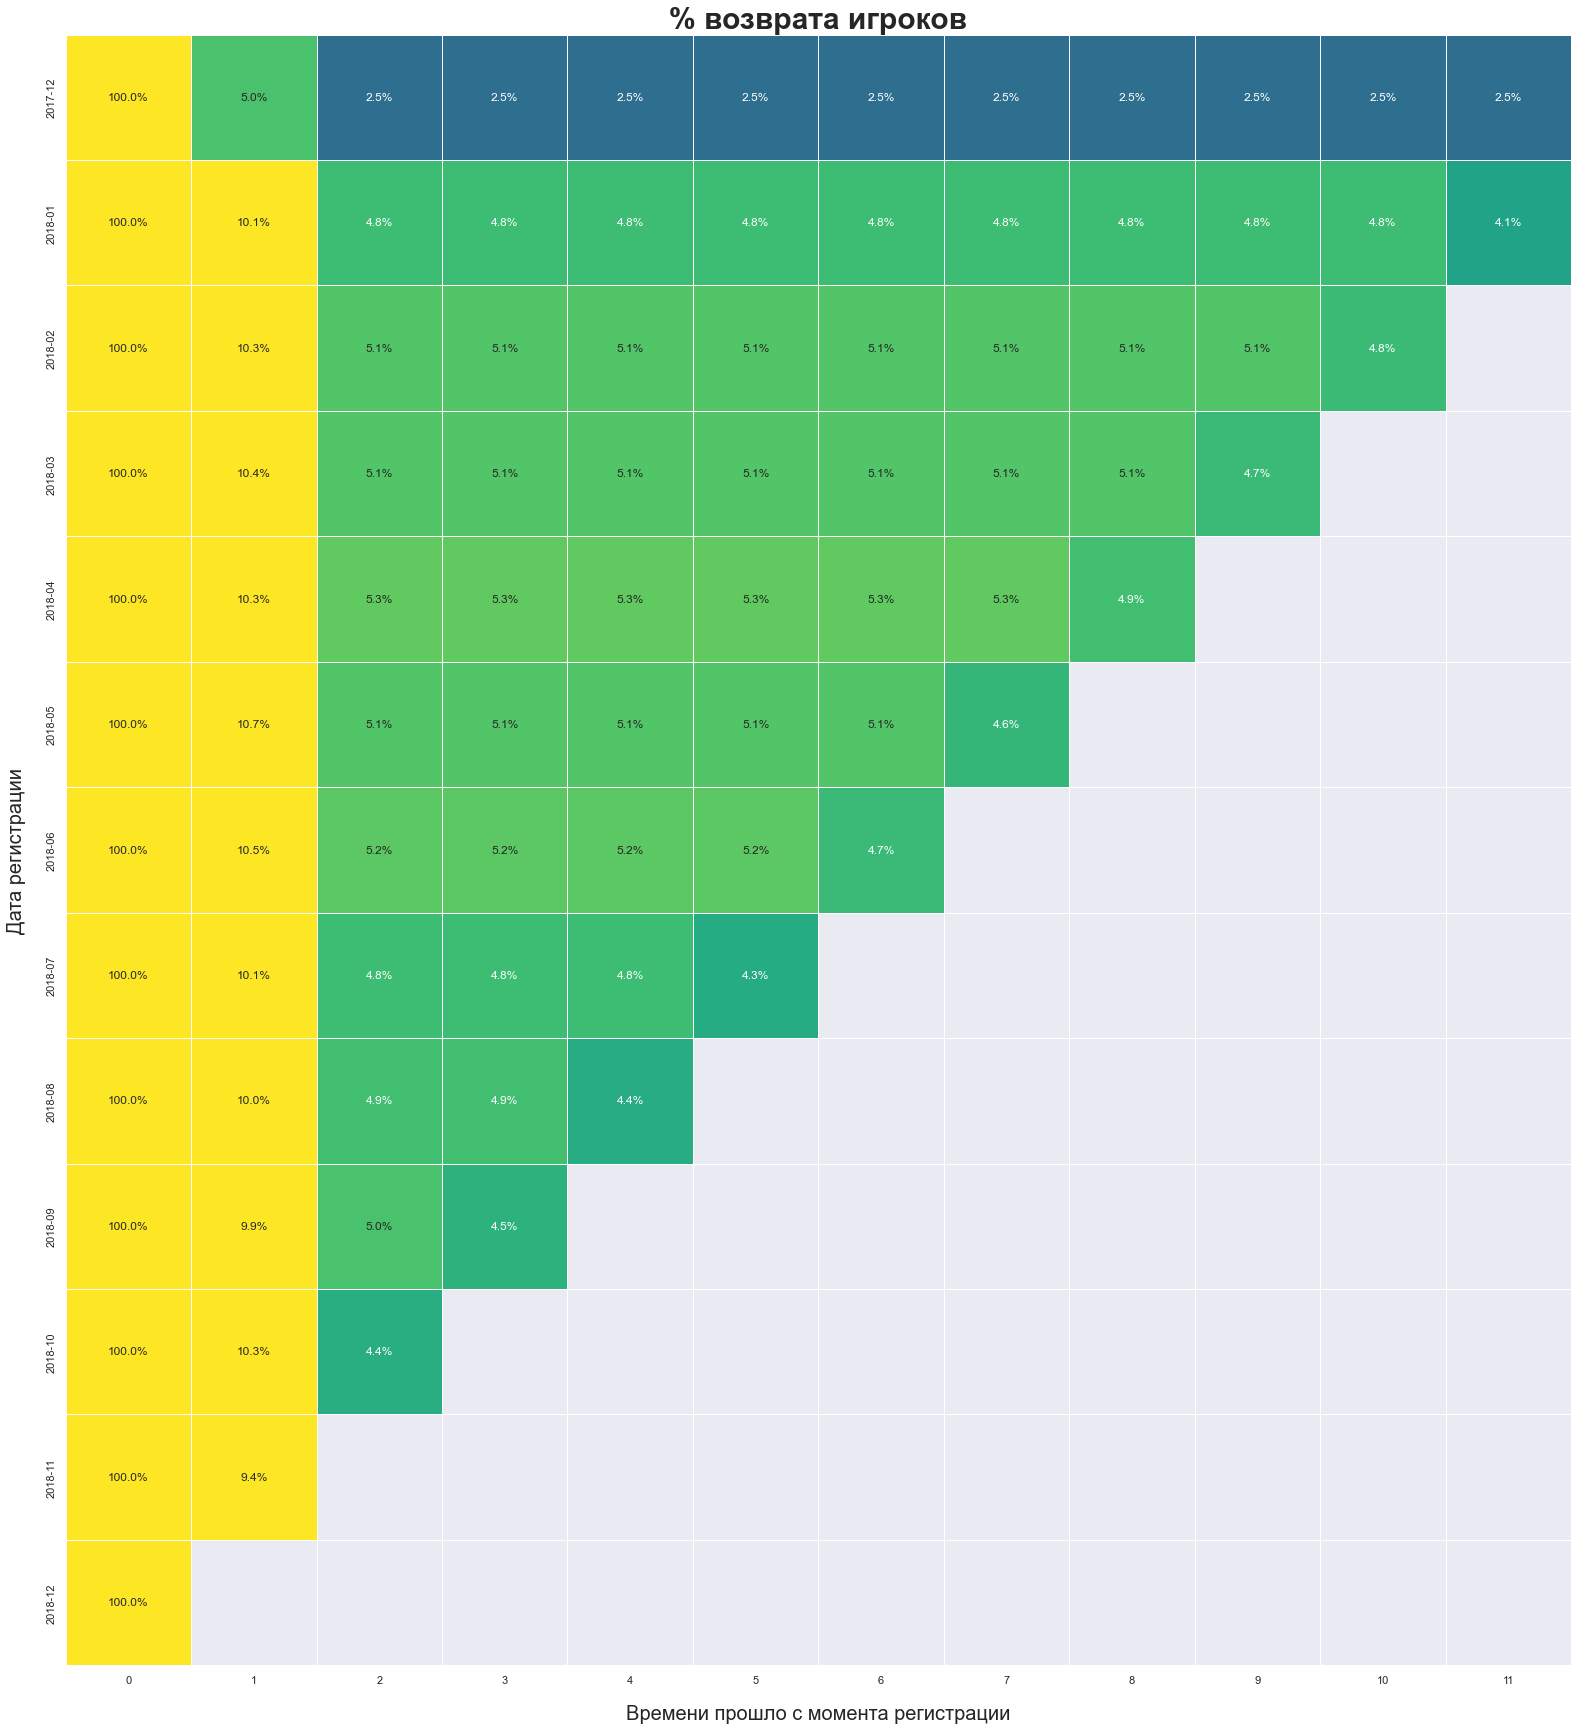

In [37]:
retention(reg_data, auth_data, 'M', '2018-01-01', '2018-12-31', 'heatmap')

'Lineplot'

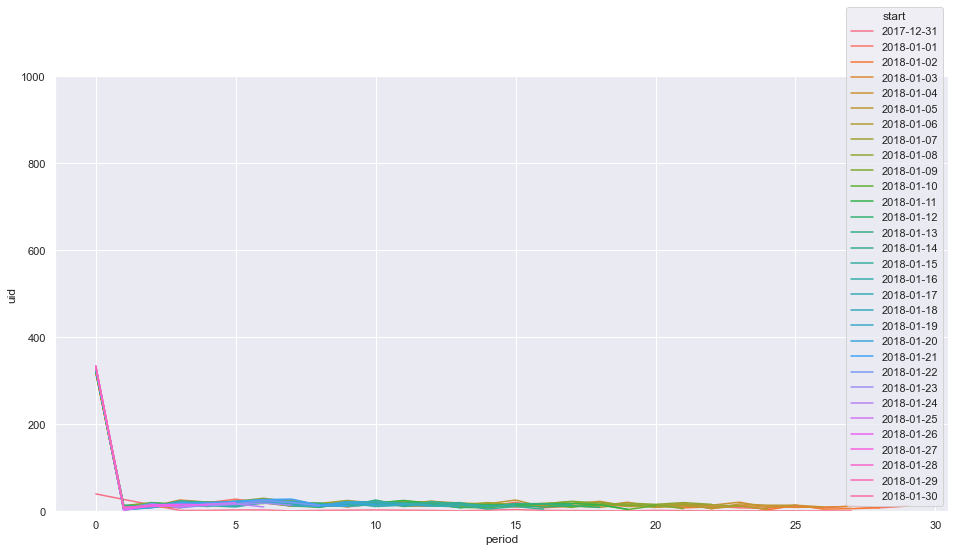

In [38]:
retention(reg_data, auth_data, 'D', '2018-01-01', '2018-01-31', 'lineplot')

In [39]:
retention(reg_data, auth_data, 'D', '2018-01-01', '2018-01-31', 'table')

period,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
start,,,,,,,,,,,,,,,,,,,,,
2017-12-31,40.0,NaN,NaN,2.0,2.0,3.0,3.0,1.0,2.0,NaN,...,2.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN
2018-01-01,320.0,5.0,11.0,8.0,20.0,28.0,19.0,12.0,11.0,18.0,...,11.0,14.0,12.0,8.0,7.0,11.0,8.0,12.0,8.0,12.0
2018-01-02,320.0,4.0,18.0,14.0,19.0,17.0,22.0,12.0,17.0,10.0,...,13.0,8.0,10.0,14.0,3.0,14.0,5.0,6.0,8.0,NaN
2018-01-03,320.0,5.0,11.0,26.0,21.0,23.0,21.0,14.0,13.0,23.0,...,9.0,19.0,6.0,13.0,11.0,9.0,10.0,11.0,NaN,NaN
2018-01-04,322.0,5.0,19.0,14.0,22.0,15.0,24.0,24.0,16.0,24.0,...,14.0,13.0,14.0,21.0,9.0,14.0,10.0,NaN,NaN,NaN
2018-01-05,321.0,5.0,19.0,15.0,16.0,15.0,27.0,26.0,15.0,19.0,...,11.0,16.0,6.0,17.0,14.0,14.0,NaN,NaN,NaN,NaN
2018-01-06,323.0,6.0,12.0,9.0,17.0,20.0,21.0,17.0,14.0,14.0,...,9.0,12.0,9.0,12.0,5.0,NaN,NaN,NaN,NaN,NaN
2018-01-07,322.0,12.0,17.0,15.0,17.0,18.0,21.0,20.0,18.0,25.0,...,14.0,16.0,15.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,324.0,10.0,19.0,17.0,18.0,23.0,30.0,21.0,18.0,15.0,...,16.0,20.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Задания 2 и 3 размещены в отдельных файлах для удобства работы с ними